# Sign Language Digits Recognition
----

Students: 
- Camilla Savarese
- Valentino Sacco
- Arturo Ghinassi
- Giorgia Fontana
- Luca Romani

## Imports

### Importing all the needed libraries

In [9]:
# utils
import numpy as np
from matplotlib.cm import *
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from statistics import median

# sklearn imports
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

# our own customized Naive Bayes
import naive_bayes_custom

# image processing imports
from PIL import Image
import cv2
from scipy.signal import convolve2d as conv2, convolve
from PIL import Image, ImageFilter
from skimage.io import imsave

# multiprocessing imports
import multiprocessing

import utils

# Setup
plt.rcParams['figure.figsize'] = (15, 8)
AVAILABLE_CPU = multiprocessing.cpu_count()

### Importing the data as numpy arrays

In [5]:
X, X_unf, Y, X_e = utils.get_dataset()

# Naive Bayes Classifier

## First approach: Multinomial NB with image processing

### Image preprocessing

In [7]:
# cleaning the image by setting as white pixels the angles of the images
subset = [0,1,2,3,4,5,6,7,8,9,10,53,54,55,56,57,58,59,60,61,62,63]

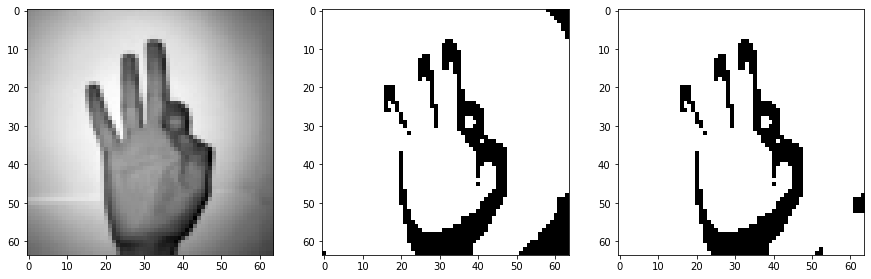

In [8]:
img = X[1]
new_img = utils.image_to_bw(img)
new_cleaned_img = np.copy(new_img)
new_cleaned_img = utils.cleaning(new_cleaned_img.reshape(64, 64), subset)

plt.subplot(1,3,1);
plt.imshow(img.reshape(64, 64), cmap='gray', interpolation='nearest');

plt.subplot(1,3,2);
plt.imshow(new_img.reshape(64, 64), cmap='gray', interpolation='nearest');

plt.subplot(1,3,3);
plt.imshow(new_cleaned_img, cmap='gray', interpolation='nearest');

### Model selection

First we have to select the best threshold to preprocess the images by doing a cross-validation with different values for the threshold

In [31]:
threshold = np.arange(0.45, 0.61, 0.01)
for th in threshold:
    
    scores = []
    
    # first we convert to b&w
    Xbw = [utils.image_to_bw(X[i], threshold = th) for i in range(len(X))]
    # then we clean the images from the dirt
    Xbw = [utils.cleaning(Xbw[i].reshape(64, 64), subset).flatten() for i in range(len(Xbw))]
    
    Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)
    modelbw = MultinomialNB()
    modelbw.fit(Xbwtrain, Ytrain)
    
    scorebw = cross_val_score(modelbw, Xbwtrain, Ytrain, cv = 20, n_jobs = AVAILABLE_CPU)
    
    scores.append(scorebw.mean())
    
    print(f'score : {scorebw.mean()}, threshold: {th}')

score : 0.4546536796536797, threshold: 0.45
score : 0.4378871128871129, threshold: 0.46
score : 0.46515151515151515, threshold: 0.47000000000000003
score : 0.4746669996669997, threshold: 0.48000000000000004
score : 0.4696053946053945, threshold: 0.49000000000000005
score : 0.47741425241425245, threshold: 0.5
score : 0.5083666333666333, threshold: 0.51
score : 0.5083666333666333, threshold: 0.52
score : 0.5116217116217117, threshold: 0.53
score : 0.5084748584748584, threshold: 0.54
score : 0.5136446886446886, threshold: 0.55
score : 0.4921994671994672, threshold: 0.56
score : 0.5084415584415585, threshold: 0.5700000000000001
score : 0.5064352314352315, threshold: 0.5800000000000001
score : 0.5154595404595405, threshold: 0.5900000000000001
score : 0.5104395604395604, threshold: 0.6000000000000001


best threshold seems to be 0.59, so let's implement the model with that threshold and test it on the test set.

In [34]:
Xbw = [utils.image_to_bw(X[i], threshold = 0.59) for i in range(len(X))]
Xbw = [utils.cleaning(Xbw[i].reshape(64, 64), subset).flatten() for i in range(len(Xbw))]

Xbwtrain, Xbwtest, Ytrain, Ytest = train_test_split(Xbw,Y)

modelbw = MultinomialNB()
modelbw.fit(Xbwtrain, Ytrain)
Ymodelbw = modelbw.predict(Xbwtest)

print(f'accuracy score for the model: {accuracy_score(Ytest, Ymodelbw)}')

accuracy score for the model: 0.5213178294573644


Not a great result, we expected more but we can work on it!

### Plots for error understanding

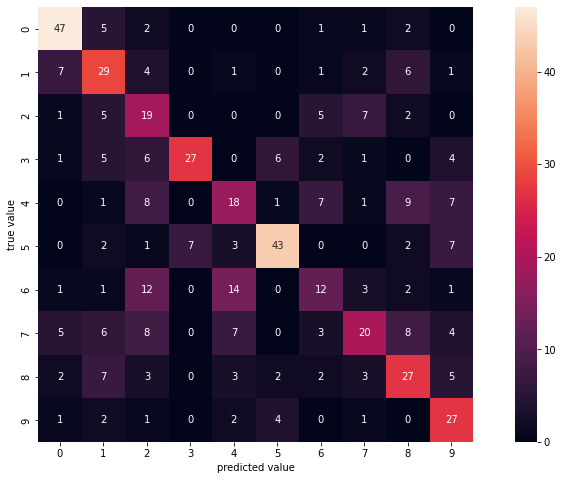

In [35]:
mat = confusion_matrix(Ytest, Ymodelbw)

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

the model sistematically fails in classifying the 6, often predicting a 2 or a 4

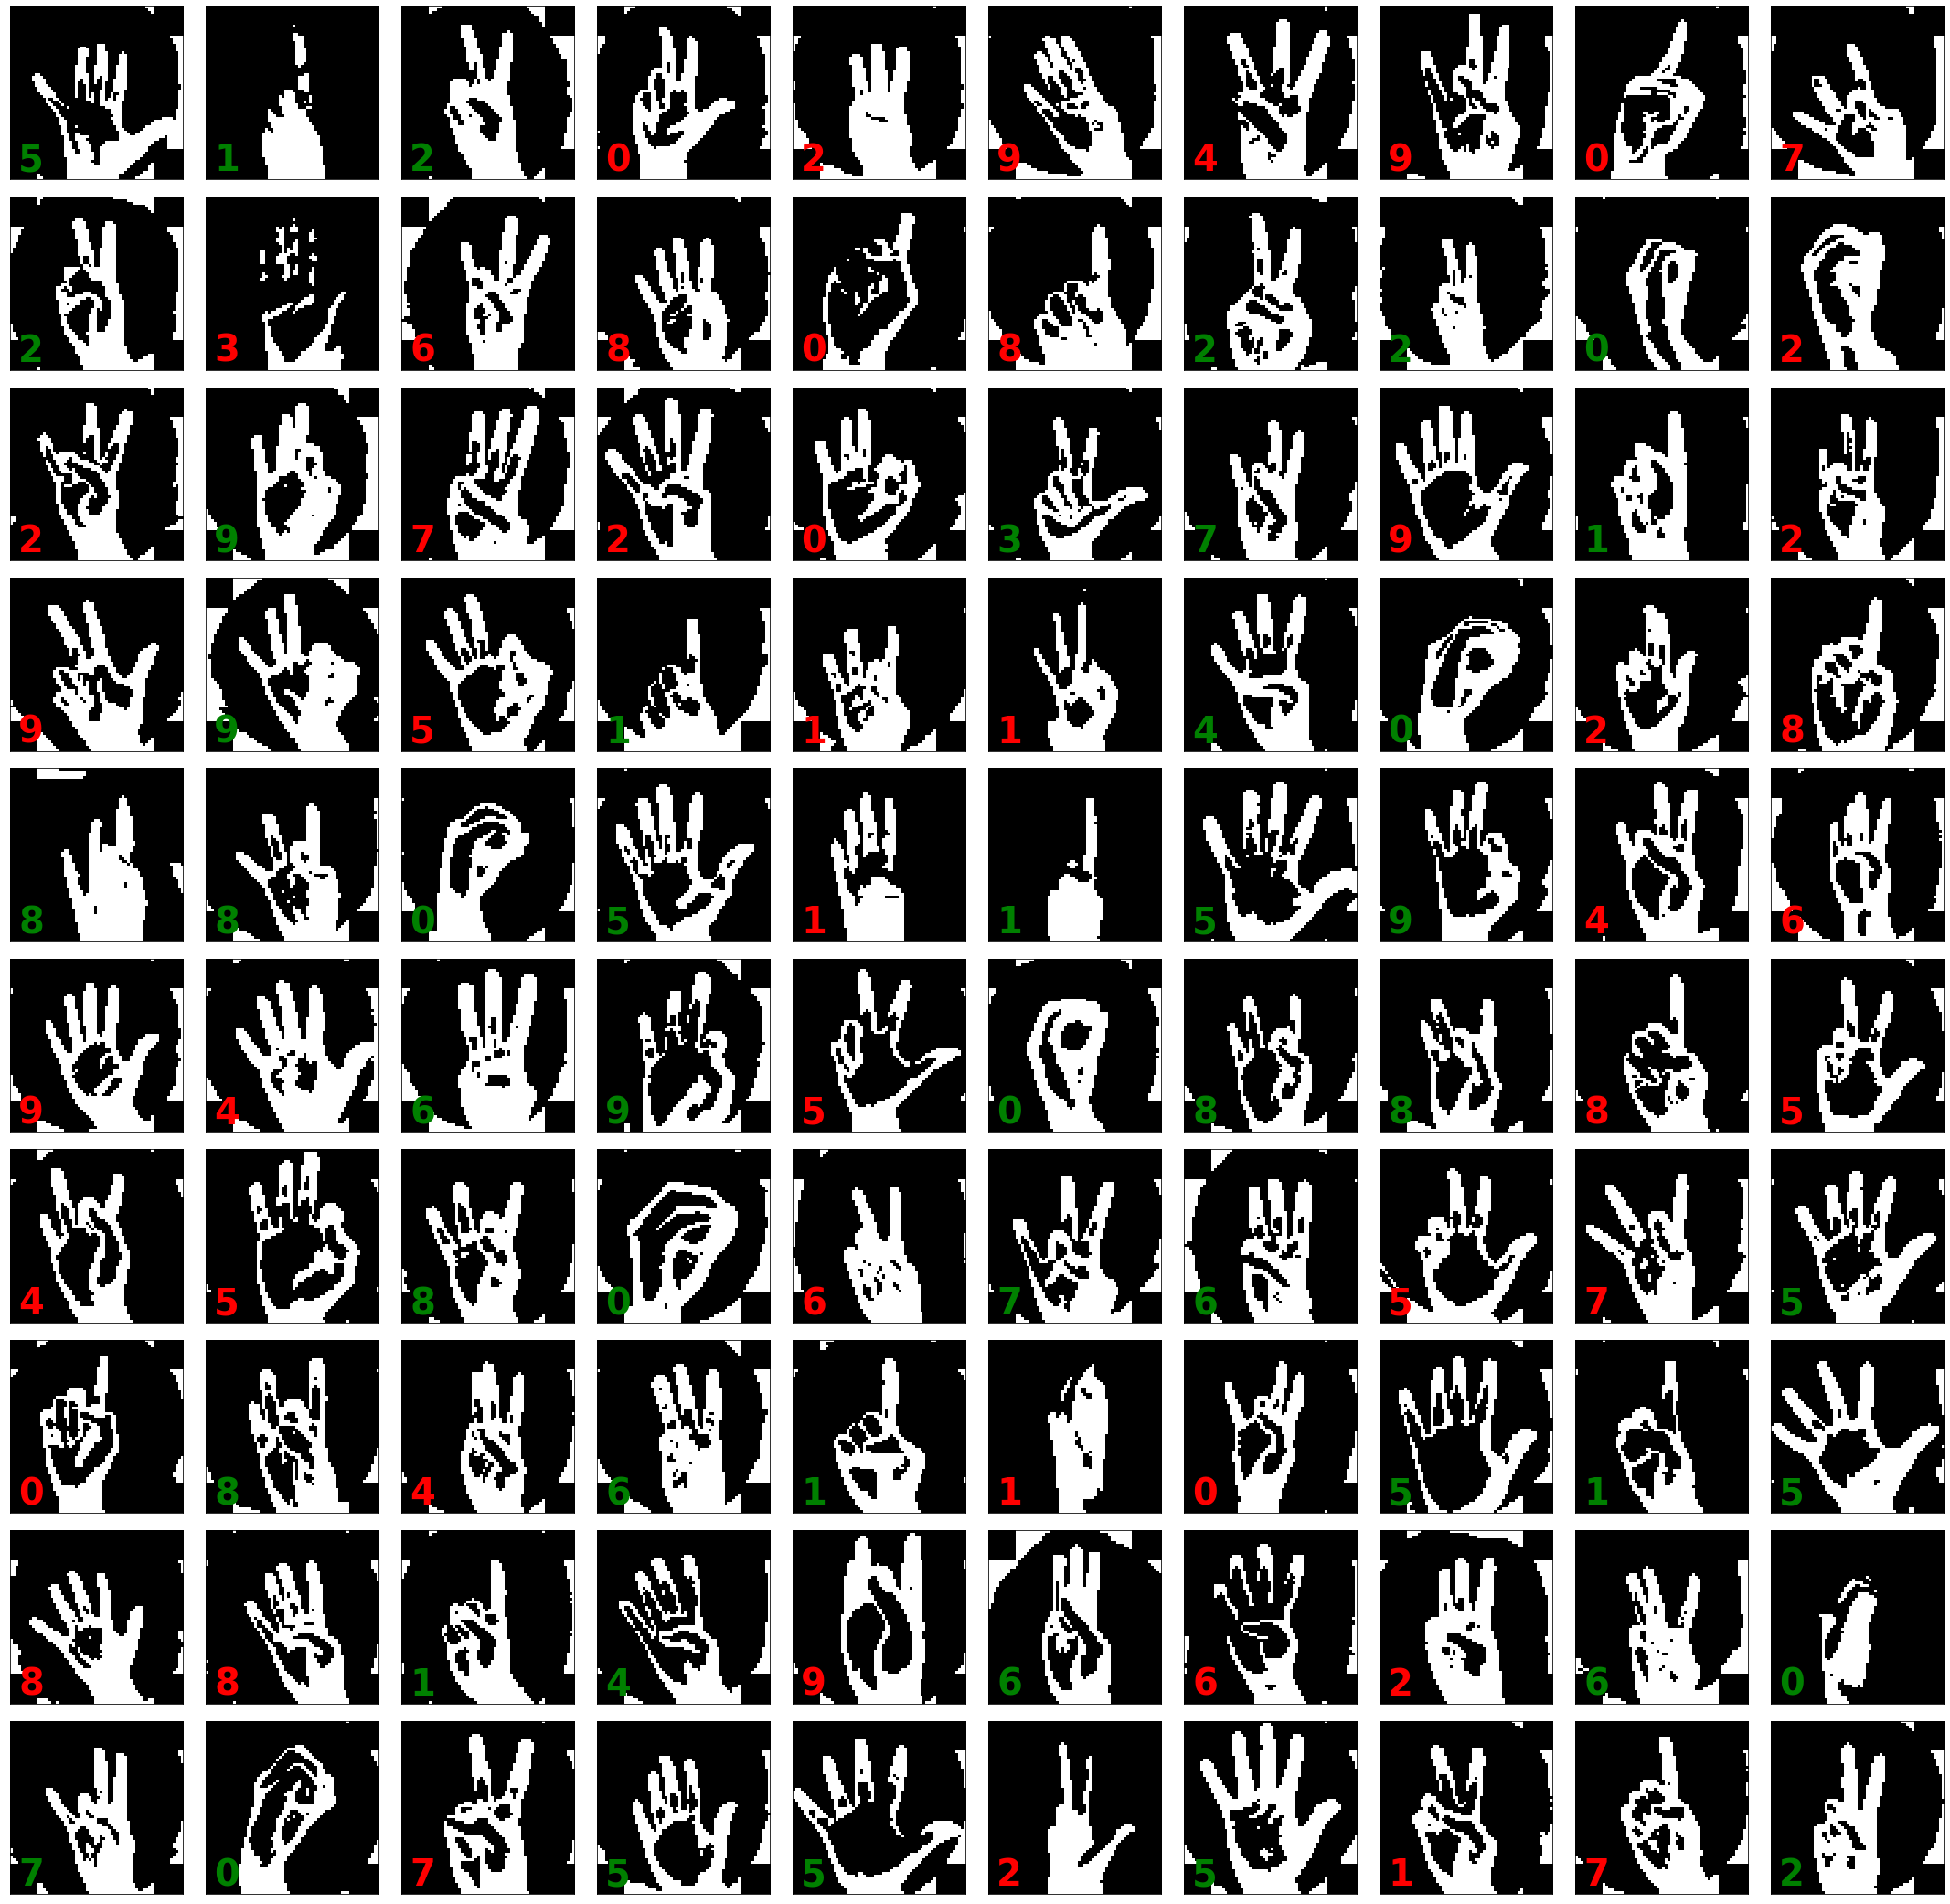

In [49]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = np.array(Xbwtest).reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodelbw[i]),
            transform=ax.transAxes, fontsize = 40, fontweight = 'bold', 
            color='green' if (Ytest[i] == Ymodelbw[i]) else 'red')

## Second approach: Gaussian NB

In this case we have no hyperparameters to set so we just procede by implementing the model training and testing it on the standard images.

### Model training and testing

In [4]:
# working with normal images
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)

In [5]:
model = naive_bayes_custom.NaiveBayesCustom()
model.fit(Xtrain, Ytrain)
Ymodel = model.predict(Xtest)

print(f'accuracy score for the model: {accuracy_score(Ytest, Ymodel)}')

accuracy score for the model: 0.6298449612403101


Definitely a great improvement compared to the Multinomial approach.

### Plots for error understanding

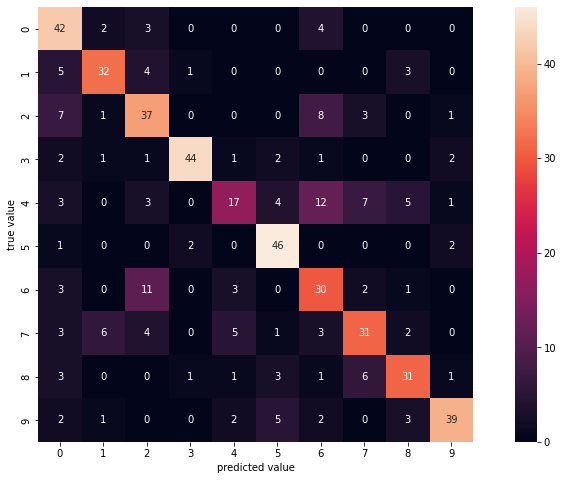

In [53]:
mat = confusion_matrix(Ytest, Ymodel)

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

Still the model miss-classifies the treu 6 predicting 2, but this time not also the 4.
Another sistematic error is predicting 6 while the true value is 4.

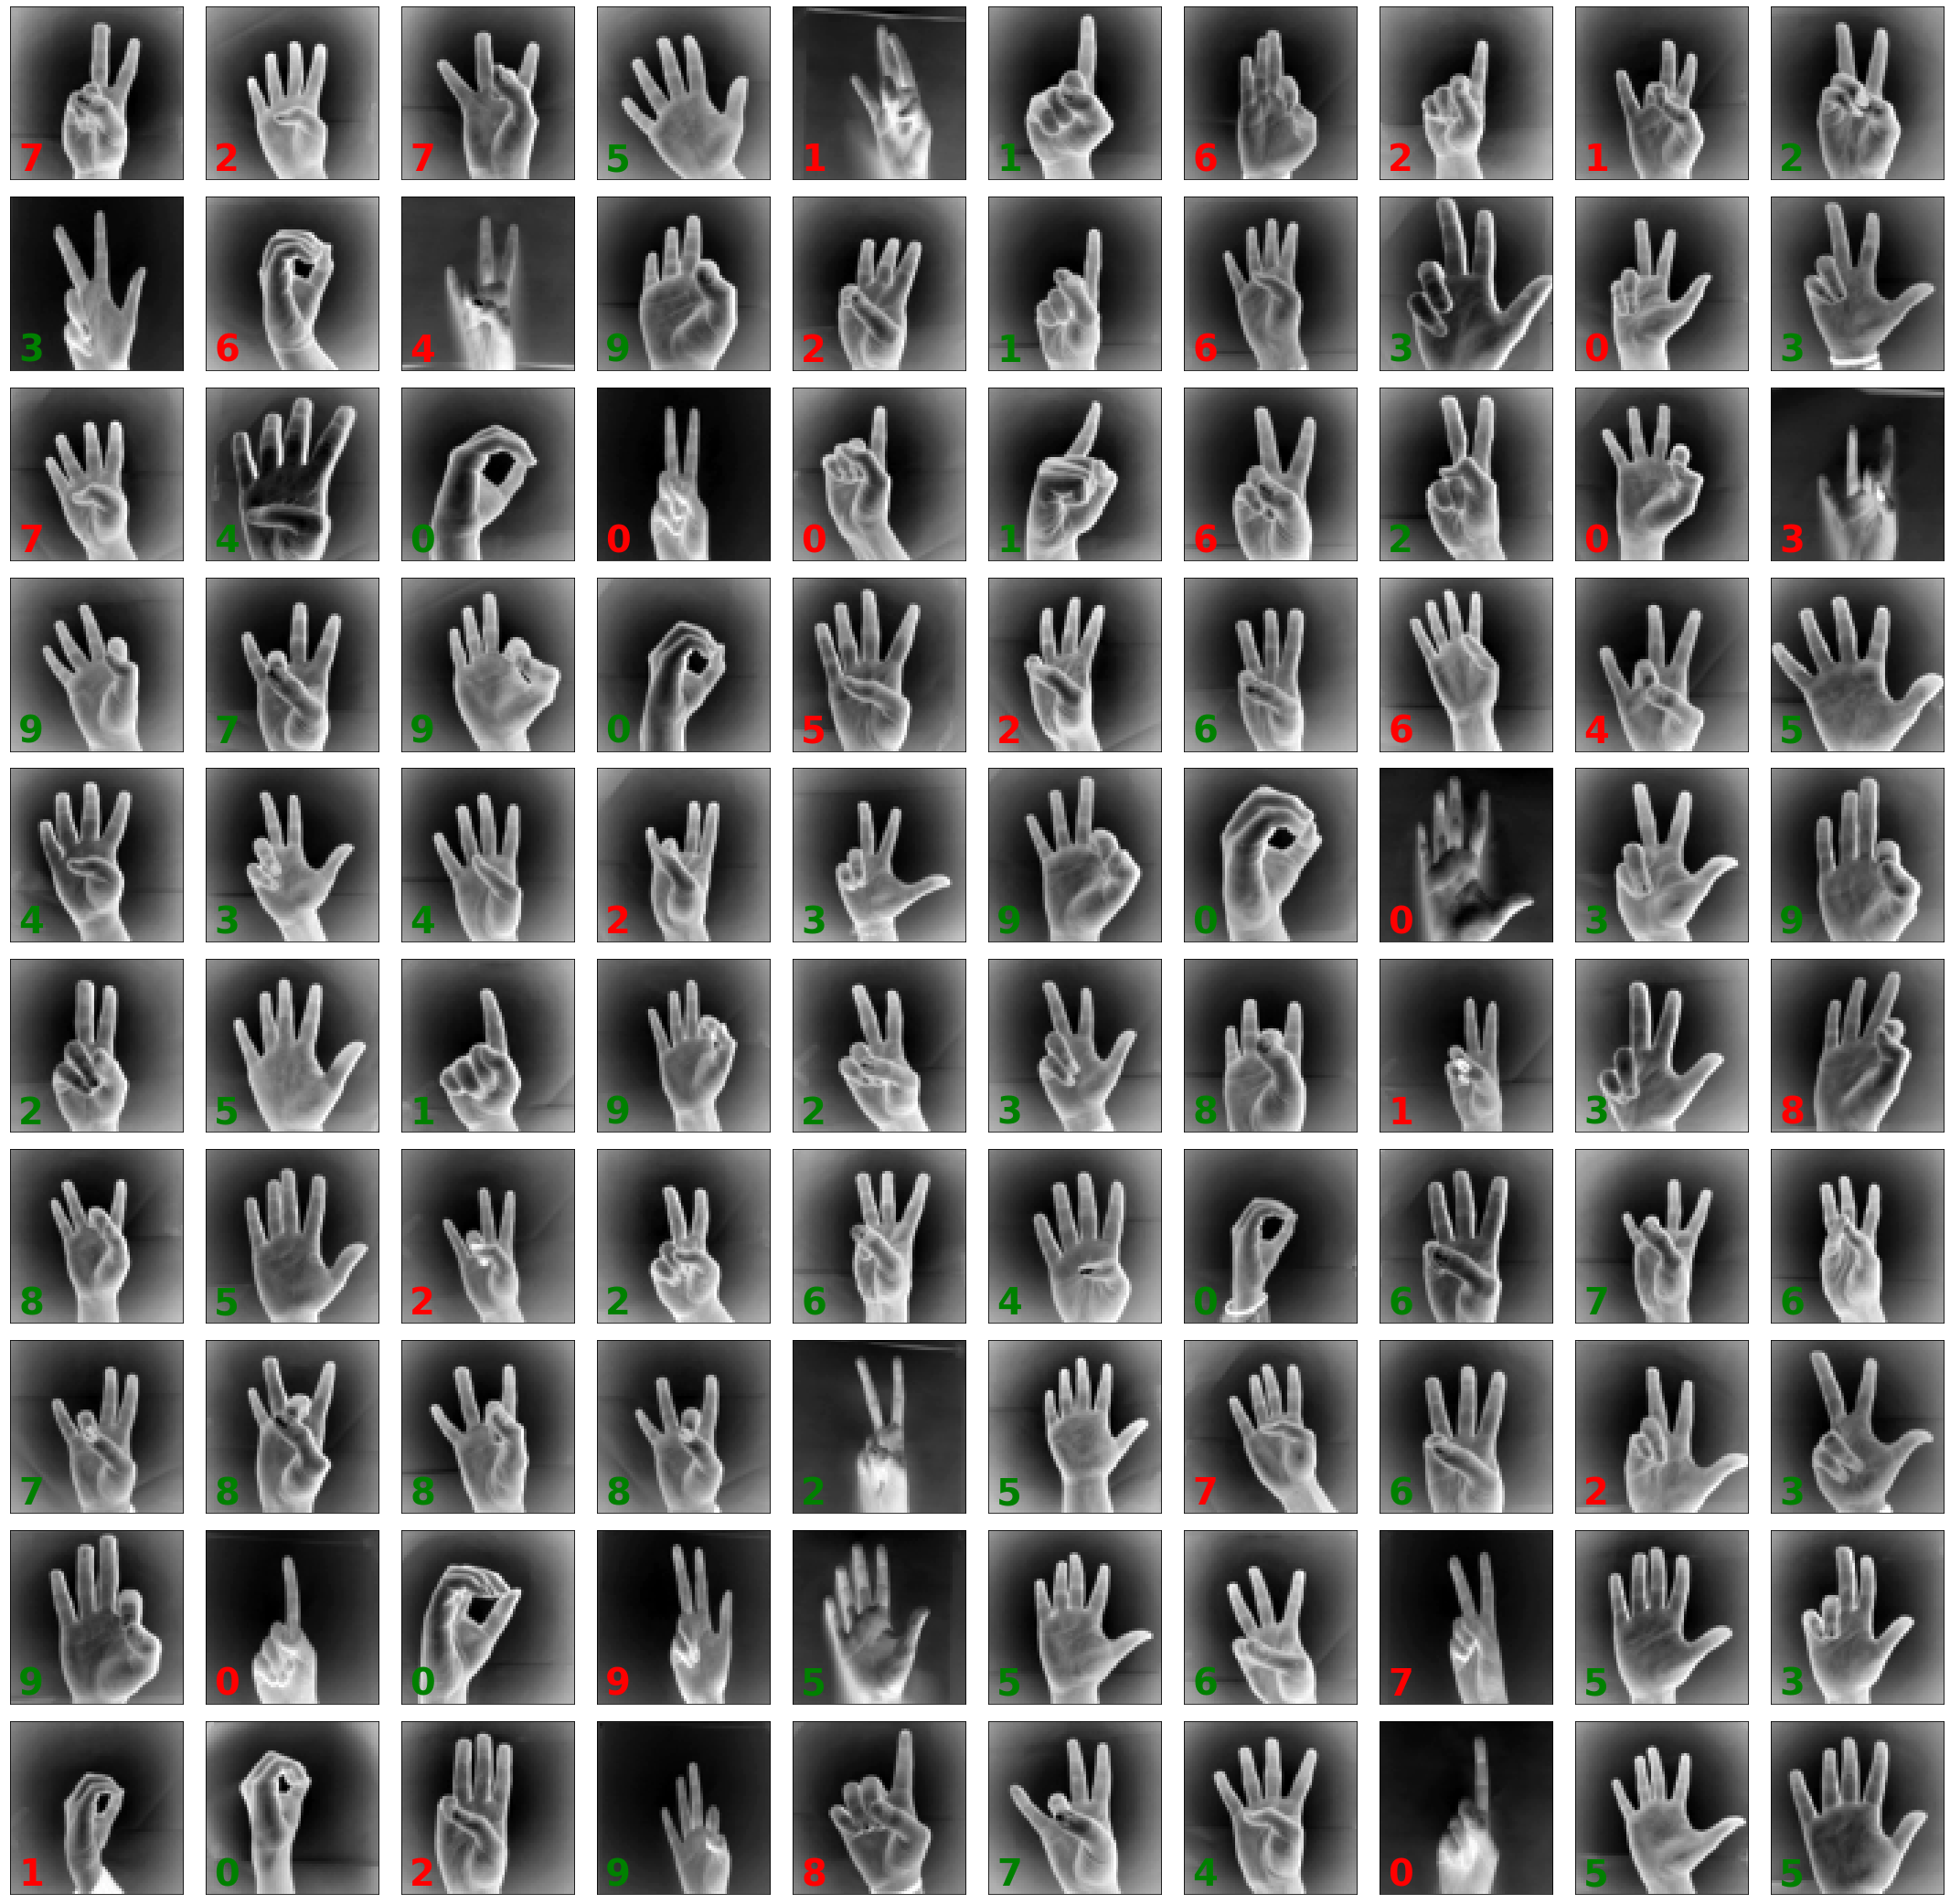

In [54]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes, fontsize = 40, fontweight = 'bold', 
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

### Custom Gaussian NB class for error understanding

We implemented our own Gaussian NB class based to have a clearer vision of what the model was doing and why/where was failing

In [ ]:
model = naive_bayes_custom.NaiveBayesCustom()
model.fit(Xtrain, Ytrain)
score = cross_val_score(model, X, Y, cv=20)
Ymodel = model.predict(Xtest)

In [ ]:
img_indexes = np.where(Y == 6)[0]
for img_index in img_indexes :
    #plt.imshow(X[img_index].reshape(64, 64), cmap='gray', interpolation='nearest')
    likes = (model.custom_predict([X[img_index]]))
    top_l = model.classes_[likes[0].argmax()]
    if(top_l != 6):
        print(f"Top likelihood is: {top_l} for index {img_index}")

Top likelihood is: 2 for index 615
Top likelihood is: 8 for index 616
Top likelihood is: 2 for index 617
Top likelihood is: 4 for index 619
Top likelihood is: 2 for index 623
Top likelihood is: 0 for index 626
Top likelihood is: 7 for index 632
Top likelihood is: 2 for index 633
Top likelihood is: 2 for index 635
Top likelihood is: 0 for index 636
Top likelihood is: 4 for index 637
Top likelihood is: 0 for index 638
Top likelihood is: 2 for index 639
Top likelihood is: 0 for index 640
Top likelihood is: 7 for index 641
Top likelihood is: 2 for index 645
Top likelihood is: 0 for index 648
Top likelihood is: 7 for index 650
Top likelihood is: 2 for index 653
Top likelihood is: 2 for index 654
Top likelihood is: 2 for index 655
Top likelihood is: 2 for index 660
Top likelihood is: 9 for index 661
Top likelihood is: 4 for index 664
Top likelihood is: 0 for index 667
Top likelihood is: 2 for index 668
Top likelihood is: 1 for index 670
Top likelihood is: 0 for index 676
Top likelihood is: 2

We ran some test and annotate the possible causes of missclassification, in most cases the problems are related with image distorsions such as inclination, luminosity or rotations of the hands.

Top likelihood is: 3 for index 813
Likelihood for class 0 : 2431.7856949387738
Likelihood for class 1 : -3084.7961703096375
Likelihood for class 2 : 1167.730139497847
Likelihood for class 3 : 3234.8730231760055
Likelihood for class 4 : 3083.5097357761347
Likelihood for class 5 : 2686.782396149008
Likelihood for class 6 : 3088.3443102074616
Likelihood for class 7 : 2182.5105516268814
Likelihood for class 8 : 2682.557167979319
Likelihood for class 9 : 2727.0063644622705


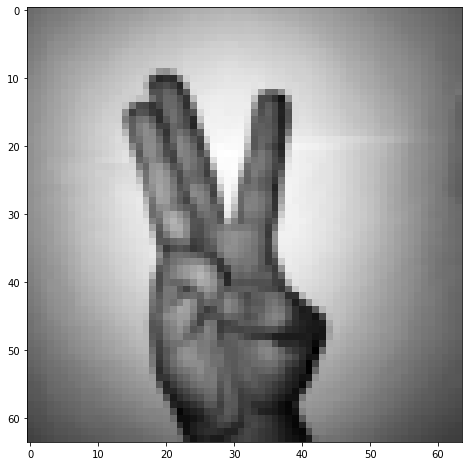

In [ ]:
# Annotations : 
# 636 nail polish
# 617 inclined 
# 653 inclined
# 813 fingers close together

img_index = 813
plt.imshow(X[img_index].reshape(64, 64), cmap='gray', interpolation='nearest')
likes = (model.custom_predict([X[img_index]]))
top_l = model.classes_[likes[0].argmax()]
if(top_l != 6):
    print(f"Top likelihood is: {top_l} for index {img_index}")
for i in range(len(model.classes_)) :
    class_l = likes[0][0][i]
    print(f"Likelihood for class {model.classes_[i]} : {class_l}")


## Improving Gaussian NB with PCA

### Normalizing the data removing the mean image

In [40]:
def compute_mean_image(X):
    '''
    computes the mean image of the dataset
    '''
    
    return np.mean(X, axis=0)

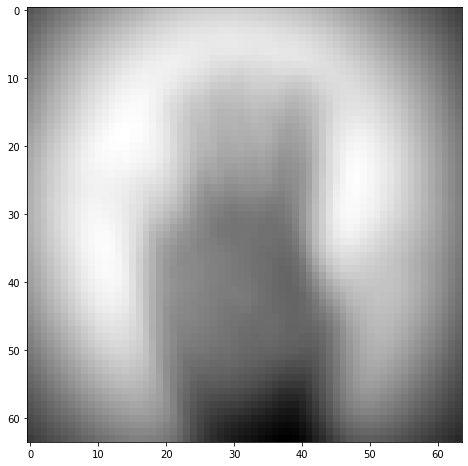

In [41]:
image_residual = compute_mean_image(X_unf)
plt.imshow(image_residual, cmap = 'gray');

Now we normalize all the images by subtracting the mean image of the dataset

In [42]:
X_without_mean = [x - image_residual for x in X_unf]
X_no_mean_flattened = [x.flatten() for x in X_without_mean]

Then we do the PCA on the normalized data

In [43]:
ncomp = 64 # number of columns

pca = PCA(n_components=ncomp)  # For example 2-PC
principalComponents = pca.fit_transform(X_no_mean_flattened[:])    

### Model selection

We have to choose the best number of components by looking at the cross validation with different number of components

In [63]:
components_chances = [35, 40, 45, 50, 55, 57, 58, 59, 60]
results = []

for comp_amount in components_chances:
    PCA_matrix = principalComponents[:, :comp_amount]

    #PCA_matrix = np.array([PCA_matrix[i].flatten() for i in range(len(PCA_matrix))])
    X_train, X_test, Y_train, Y_test = train_test_split(PCA_matrix,Y)
    model = GaussianNB()
    model.fit(X_train, Y_train)
    score = cross_val_score(model, X_train, Y_train, cv=LeaveOneOut(), n_jobs = AVAILABLE_CPU)
    
    results.append(score.mean())
    

In [64]:
for i in range(len(results)):
    print(f"avg score obtained with {components_chances[i]} components : {results[i]}")

avg score obtained with 35 components : 0.720569210866753
avg score obtained with 40 components : 0.7192755498059509
avg score obtained with 45 components : 0.7134540750323415
avg score obtained with 50 components : 0.722509702457956
avg score obtained with 55 components : 0.7309184993531694
avg score obtained with 57 components : 0.7283311772315654
avg score obtained with 58 components : 0.7296248382923674
avg score obtained with 59 components : 0.7250970245795602
avg score obtained with 60 components : 0.7153945666235446


We select 55 as the best number of components. Now we can test the model.

### Model training and testing

In [103]:
PCA_matrix = principalComponents[:, :55]
X_train, X_test, Y_train, Y_test = train_test_split(PCA_matrix,Y)

model = GaussianNB()
model.fit(X_train, Y_train)
Ymodel = model.predict(X_test)

print(f'accuracy score for the model: {accuracy_score(Y_test, Ymodel)}')

accuracy score for the model: 0.7635658914728682


We see how taking into account only the most relevant features of the images by doing the PCA the accuracy of the model improves relevantly.

### Plot for error understanding

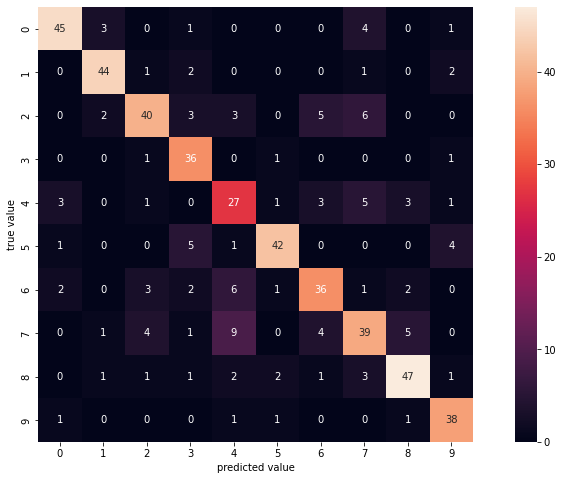

In [104]:
mat = confusion_matrix(Ymodel, Y_test)

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

With the PCA the model mostly improved in the correct classification of the 4 and the 6 that were systematically missclassified in the Vanilla Gaussian NB

## Improving Multinomial NB with Edge Detection

### Image processing

Transforming the numpy arrays in png images to apply the edge detection

In [12]:
for i in range(len(X_unf)):
    
    # given images in range [0,1] we have to normalize them using Min-Max and rescaling them to RGB
    I = cv2.normalize(X_unf[i], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U) 
    name = f'./png/train{i}.png'
    imsave(name, I)
    image = Image.open(name)
    
    # reconvert to grayscale
    image = image.convert("L")
    
    # Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
    image = image.filter(ImageFilter.FIND_EDGES)
    
    # Saving the Image Under the name test{i}.png
    image.save(name)

Plotting an example of processed image with edge detection.
We can clearly see an improvement in the quality of the image compared to the first processing we had for the first approach with Multinomial NB.

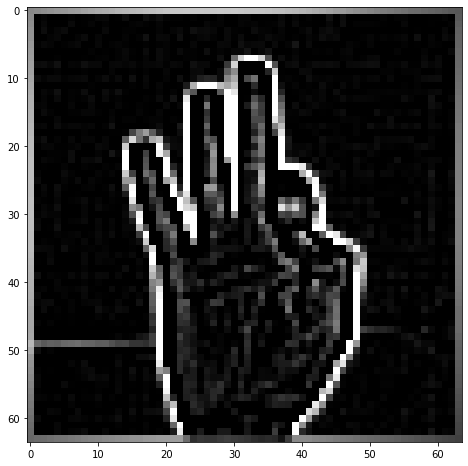

In [112]:
img = Image.open('./png/train1.png')
plt.imshow(np.asarray(img), cmap='gray');

Once we have the PNG of the original images, processed with edge detection, we have to reconvert them to numpy arrays to implement the model. This step has been already been done in the function to load the dataset at the start.

The dataset we will work with in this case is __X_e__

###  Training and testing the model

In [205]:
X_e_train, X_e_test, Ytrain, Ytest = train_test_split(X_e,Y)

model = MultinomialNB()
model.fit(X_e_train, Ytrain)
Ymodel = model.predict(X_e_test)

print(f'accuracy score for the model: {accuracy_score(Ytest, Ymodel)}')

accuracy score for the model: 0.686046511627907


A great improvement compared to our first approach considering that now we have almost the same results we had with Vanilla Gaussian NB.

### Plots for error understanding

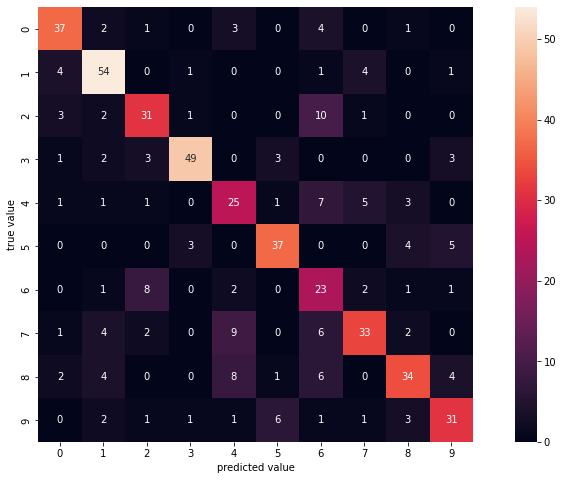

In [206]:
mat = confusion_matrix(Ytest, Ymodel)

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

The model systematically predicts 6 instead of the true label 2, we have similar errors also for predicted 4 while true 8, 7 and predicted 2 while true 6.  

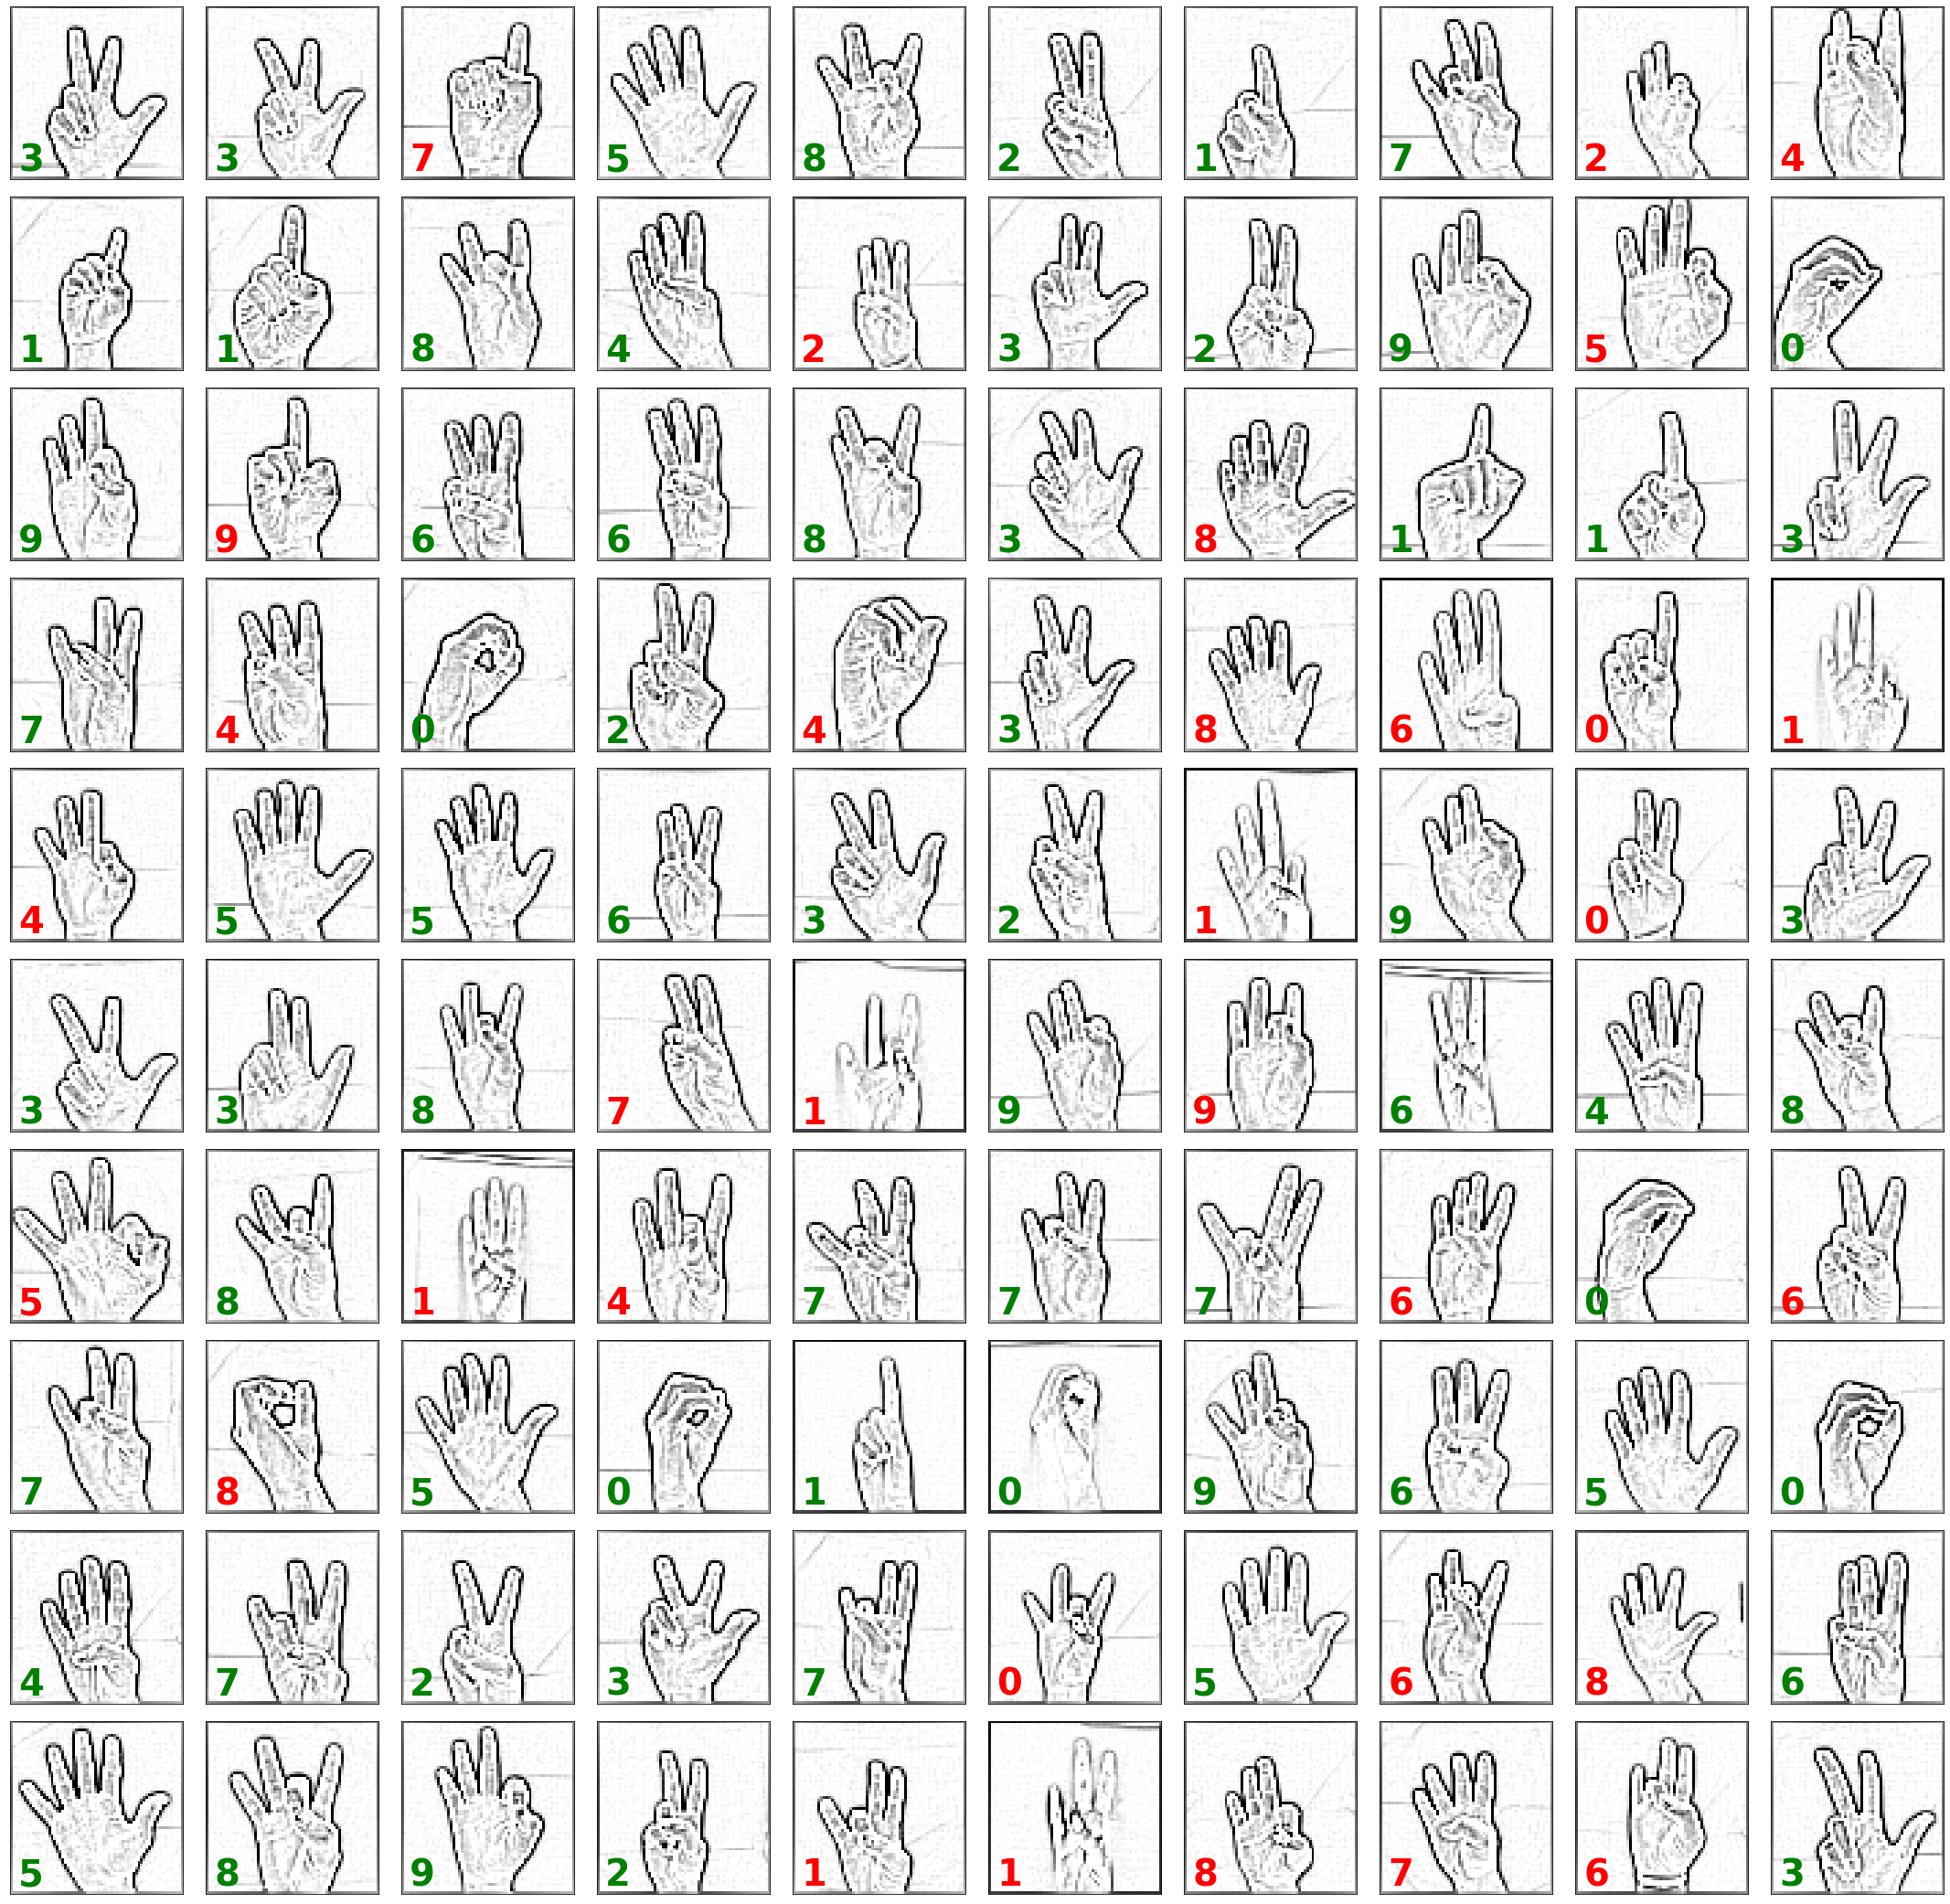

In [207]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = X_e_test.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes, fontsize = 40, fontweight = 'bold',
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

# Chamfer distance

Once we have the edge detected images we would like to compute the chamfer distance.

### Implementing the Chamfer distance

In [5]:
def chamfer_distance(x, y, metric='l2', direction='x_to_y'):
    """
    Chamfer distance between two point clouds
    Parameters
    ----------
    x: numpy array [n_points_x, n_dims]
    y: numpy array [n_points_y, n_dims]
    
    metric: metric to use for distance computation. Any metric from scikit-learn or scipy.spatial.distance can be used.
            OSS: the used direction of Chamfer distance is 'x_to_y' --->  computes average minimal distance from every point in x to y

    Returns
    -------
    chamfer_dist: float
    """
    y_nn = NearestNeighbors(n_neighbors=1, leaf_size=1, algorithm='kd_tree', metric=metric).fit(y)
    min_x_to_y = y_nn.kneighbors(x)[0]

    chamfer_dist = np.mean(min_x_to_y)

        
    return chamfer_dist

### Implementing the "model"

Given the fact we don't have a true model, we thought the best way to procede was to take a subset of train images for each class, then compute the Chamfer with the test image and take the average distance with the images of the class to classificate.

In [12]:
def testSet_chamfer(X, k):
    
    '''
    This function creates a random test set for the chamfer distance computation
    Input:
        - X: the matrix with the numpy images flattened
        - k: number of images to pick at random from each class
    Output:
        - A matrix of k images for each class
    '''
    
    n_classes = 10
    flattened_image_length = 4096
    X_test = np.empty((0))
    
    lower = [0, 204, 409, 615, 822, 1028, 1236, 1443, 1649, 1855]
    upper = [203, 408, 614, 821, 1027, 1235, 1442, 1648, 1854, 2061]
    
    for i in range(len(lower)):
        class_digit = X[lower[i]:upper[i]]
        sample = class_digit[np.random.choice(class_digit.shape[0], k, replace=False)]
        for image in sample:
            X_test = np.append(X_test, image)
            
    return X_test.reshape(k*n_classes, flattened_image_length)


In [29]:
k = 7
Chamfer_test = testSet_chamfer(X_e, k)

In [31]:
digits = [9, 0, 7, 6, 1, 8, 4, 3, 2, 5]

score_mean = 0
M = 100

for m in range(M):

    digit_score_mean = []
    
    idx = np.random.choice(X_e.shape[0])
    test = X_e[idx].reshape(64, 64)

    for i in range(len(digits)):
        score = []
        class_k = Chamfer_test[(i*k):(i*k)+4]

        for el in class_k:
            score.append(chamfer_distance(test, el.reshape(64, 64)))

        digit_score_mean.append(np.mean(score))

    best_mean = min(digit_score_mean)
    
    best_mean_class = digits[np.where(digit_score_mean == best_mean)[0][0]]
    
    ground = Y[idx]
    
    if best_mean_class == ground: score_mean += 1
    
print(f'Score: {score_mean/M}')

Score: 0.25


We tried different options but this is the best result we had so far, not a great deal.

# SVM classifier

## First approach: standard dataset

For the selection of the hyperparameters we did the cross-validation with different levels of gamma and C and the best option seemed to be gamma = 'scale' (1 / (n_features * X.var()) ) and C = 100.

### Model training and testing

In [33]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y)

In [34]:
svc = svm.SVC(gamma = 'scale', C = 100) 
svc.fit(Xtrain , Ytrain)
Ymodel = svc.predict(Xtest)

print(f'Accuracy: {accuracy_score(Ytest, Ymodel)}')

Accuracy: 0.8604651162790697


### Plots for error understanding

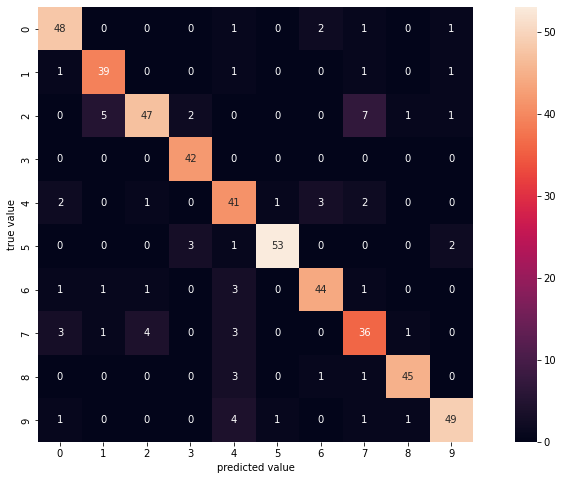

In [35]:
mat = confusion_matrix(Ytest, Ymodel)

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

We can see that the model works really well, only some troubles predicting 7's instead 2.

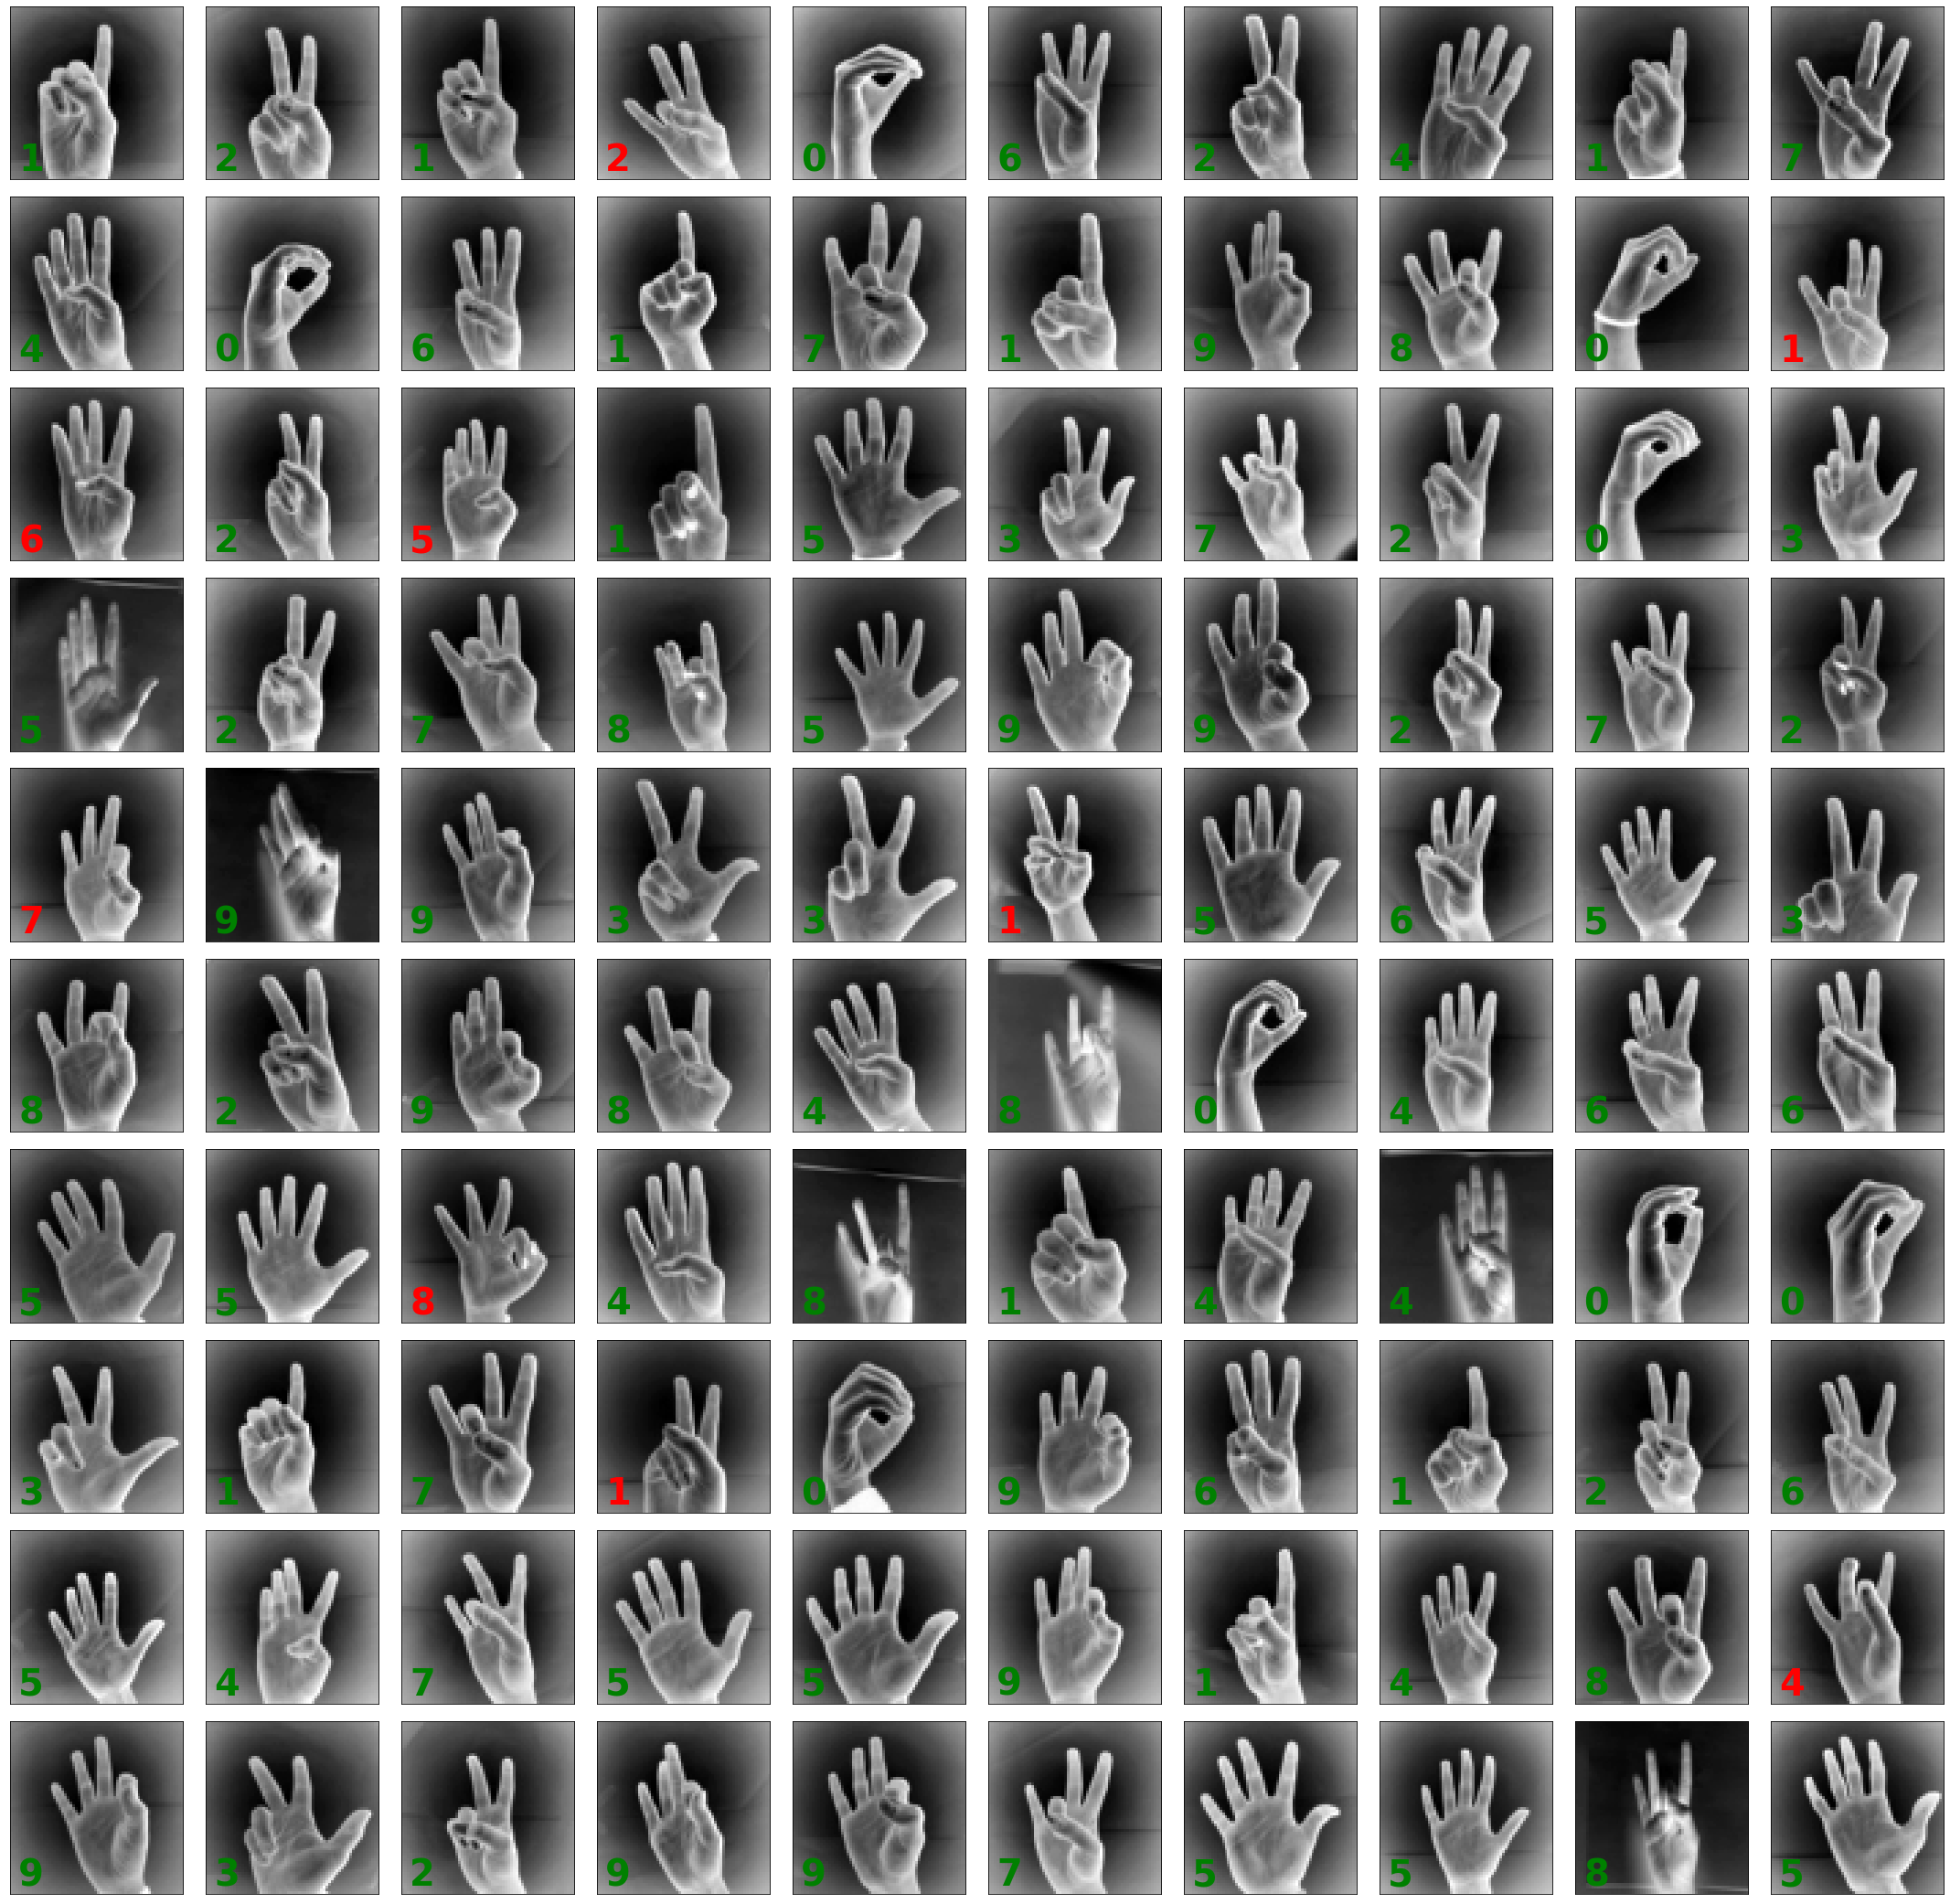

In [36]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = Xtest.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes, fontsize = 40, fontweight = 'bold',
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')

## Second approach: PCA

### Choosing number of components

In [193]:
components_chances = np.arange(40, 60, 1)
results = []

for comp_amount in components_chances:
    PCA_matrix = principalComponents[:, :comp_amount]

    #PCA_matrix = np.array([PCA_matrix[i].flatten() for i in range(len(PCA_matrix))])
    X_train, X_test, Y_train, Y_test = train_test_split(PCA_matrix,Y)
    svc = svm.SVC(gamma = 'scale', C = 100) 
    svc.fit(X_train , Y_train)  # predict on test data
    
    score = cross_val_score(svc, X_train, Y_train, cv=20, n_jobs = AVAILABLE_CPU)
    results.append(score.mean())   

In [194]:
for i in range(len(results)):
    print(f"avg score obtained with {components_chances[i]} components : {results[i]}")

avg score obtained with 40 components : 0.8596653346653346
avg score obtained with 41 components : 0.864094239094239
avg score obtained with 42 components : 0.8570263070263071
avg score obtained with 43 components : 0.8680153180153181
avg score obtained with 44 components : 0.8602564102564104
avg score obtained with 45 components : 0.8615800865800866
avg score obtained with 46 components : 0.8576506826506828
avg score obtained with 47 components : 0.8608891108891109
avg score obtained with 48 components : 0.8713120213120211
avg score obtained with 49 components : 0.873118548118548
avg score obtained with 50 components : 0.8661754911754912
avg score obtained with 51 components : 0.8680402930402931
avg score obtained with 52 components : 0.879004329004329
avg score obtained with 53 components : 0.8660672660672661
avg score obtained with 54 components : 0.8803030303030301
avg score obtained with 55 components : 0.8796786546786548
avg score obtained with 56 components : 0.8654345654345654


### Model training and testing

In [91]:
PCA_matrix = principalComponents[:, :57]
XtrainPCA, XtestPCA, Ytrain, Ytest = train_test_split(PCA_matrix,Y)

In [92]:
svc = svm.SVC(gamma = 'scale', C = 100) 
svc.fit(XtrainPCA , Ytrain)  # predict on test data
Ymodel = svc.predict(XtestPCA)

print(f'accuracy score for the model: {accuracy_score(Ytest, Ymodel)}')

accuracy score for the model: 0.8953488372093024


Almost 90%, the model was already great but we managed to improve it!

### Plots for error understanding

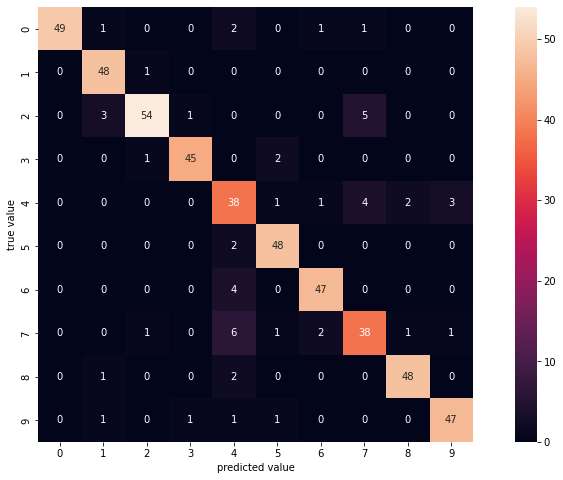

In [93]:
mat = confusion_matrix(Ymodel, Ytest)

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

Same as before, main problem predicting 7 instead of 2

## SVM with gaussian smoothed images

We tried different level of sigma and with cross-validation the best working seemed to be 2

### Filtering the images

In [97]:
def gauss(sigma):
    
    # Gaussian distribution definition
    gaussian = lambda y : (1 / (math.sqrt(2*math.pi) * sigma) ) * math.exp(- (y**2) / (2*(sigma**2)))  
    # Filtering X on filter definition interval 
    x = np.arange(-3*sigma, (3*sigma)+0.01)
    # Applying gaussian to filtered points
    Gx = list(map(gaussian, x))
    
    return Gx , x

def gaussfiltering(img, sigma):
    Gx,x = gauss(sigma)
    # Gaussian filter
    Gx = np.array(Gx)
    gauss_filter = np.outer(Gx,Gx.transpose())
    # Smoothing the image by convolving it with kernel and keeping same size, centered
    smooth_img = conv2(img,gauss_filter, mode='same', boundary='fill')
    return np.array(smooth_img)

In [98]:
Xgauss = np.array([gaussfiltering(X_unf[i], 2).flatten() for i in range(len(X_unf))])

### Model training and testing

In [105]:
XtrainGauss, XtestGauss, Ytrain, Ytest = train_test_split(Xgauss, Y)

svc = svm.SVC(gamma = 'scale', C = 100) 
svc.fit(XtrainGauss , Ytrain)  # predict on test data
Ymodel = svc.predict(XtestGauss)

print(f'accuracy score for the model: {accuracy_score(Ytest, Ymodel)}')

accuracy score for the model: 0.9069767441860465


FINALLY!!! We achieved 90% of accuracy.

### Plots for error understanding

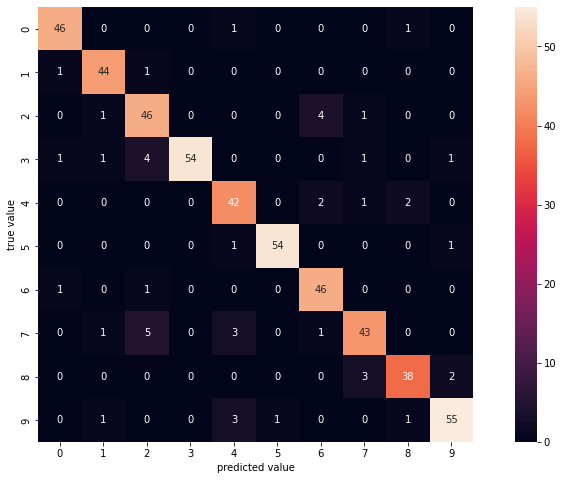

In [106]:
mat = confusion_matrix(Ytest, Ymodel)

sns.heatmap(mat, square=True, annot=True, cbar=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

The slight difference with the PCA has been made by classifying better the 7's with the 2's

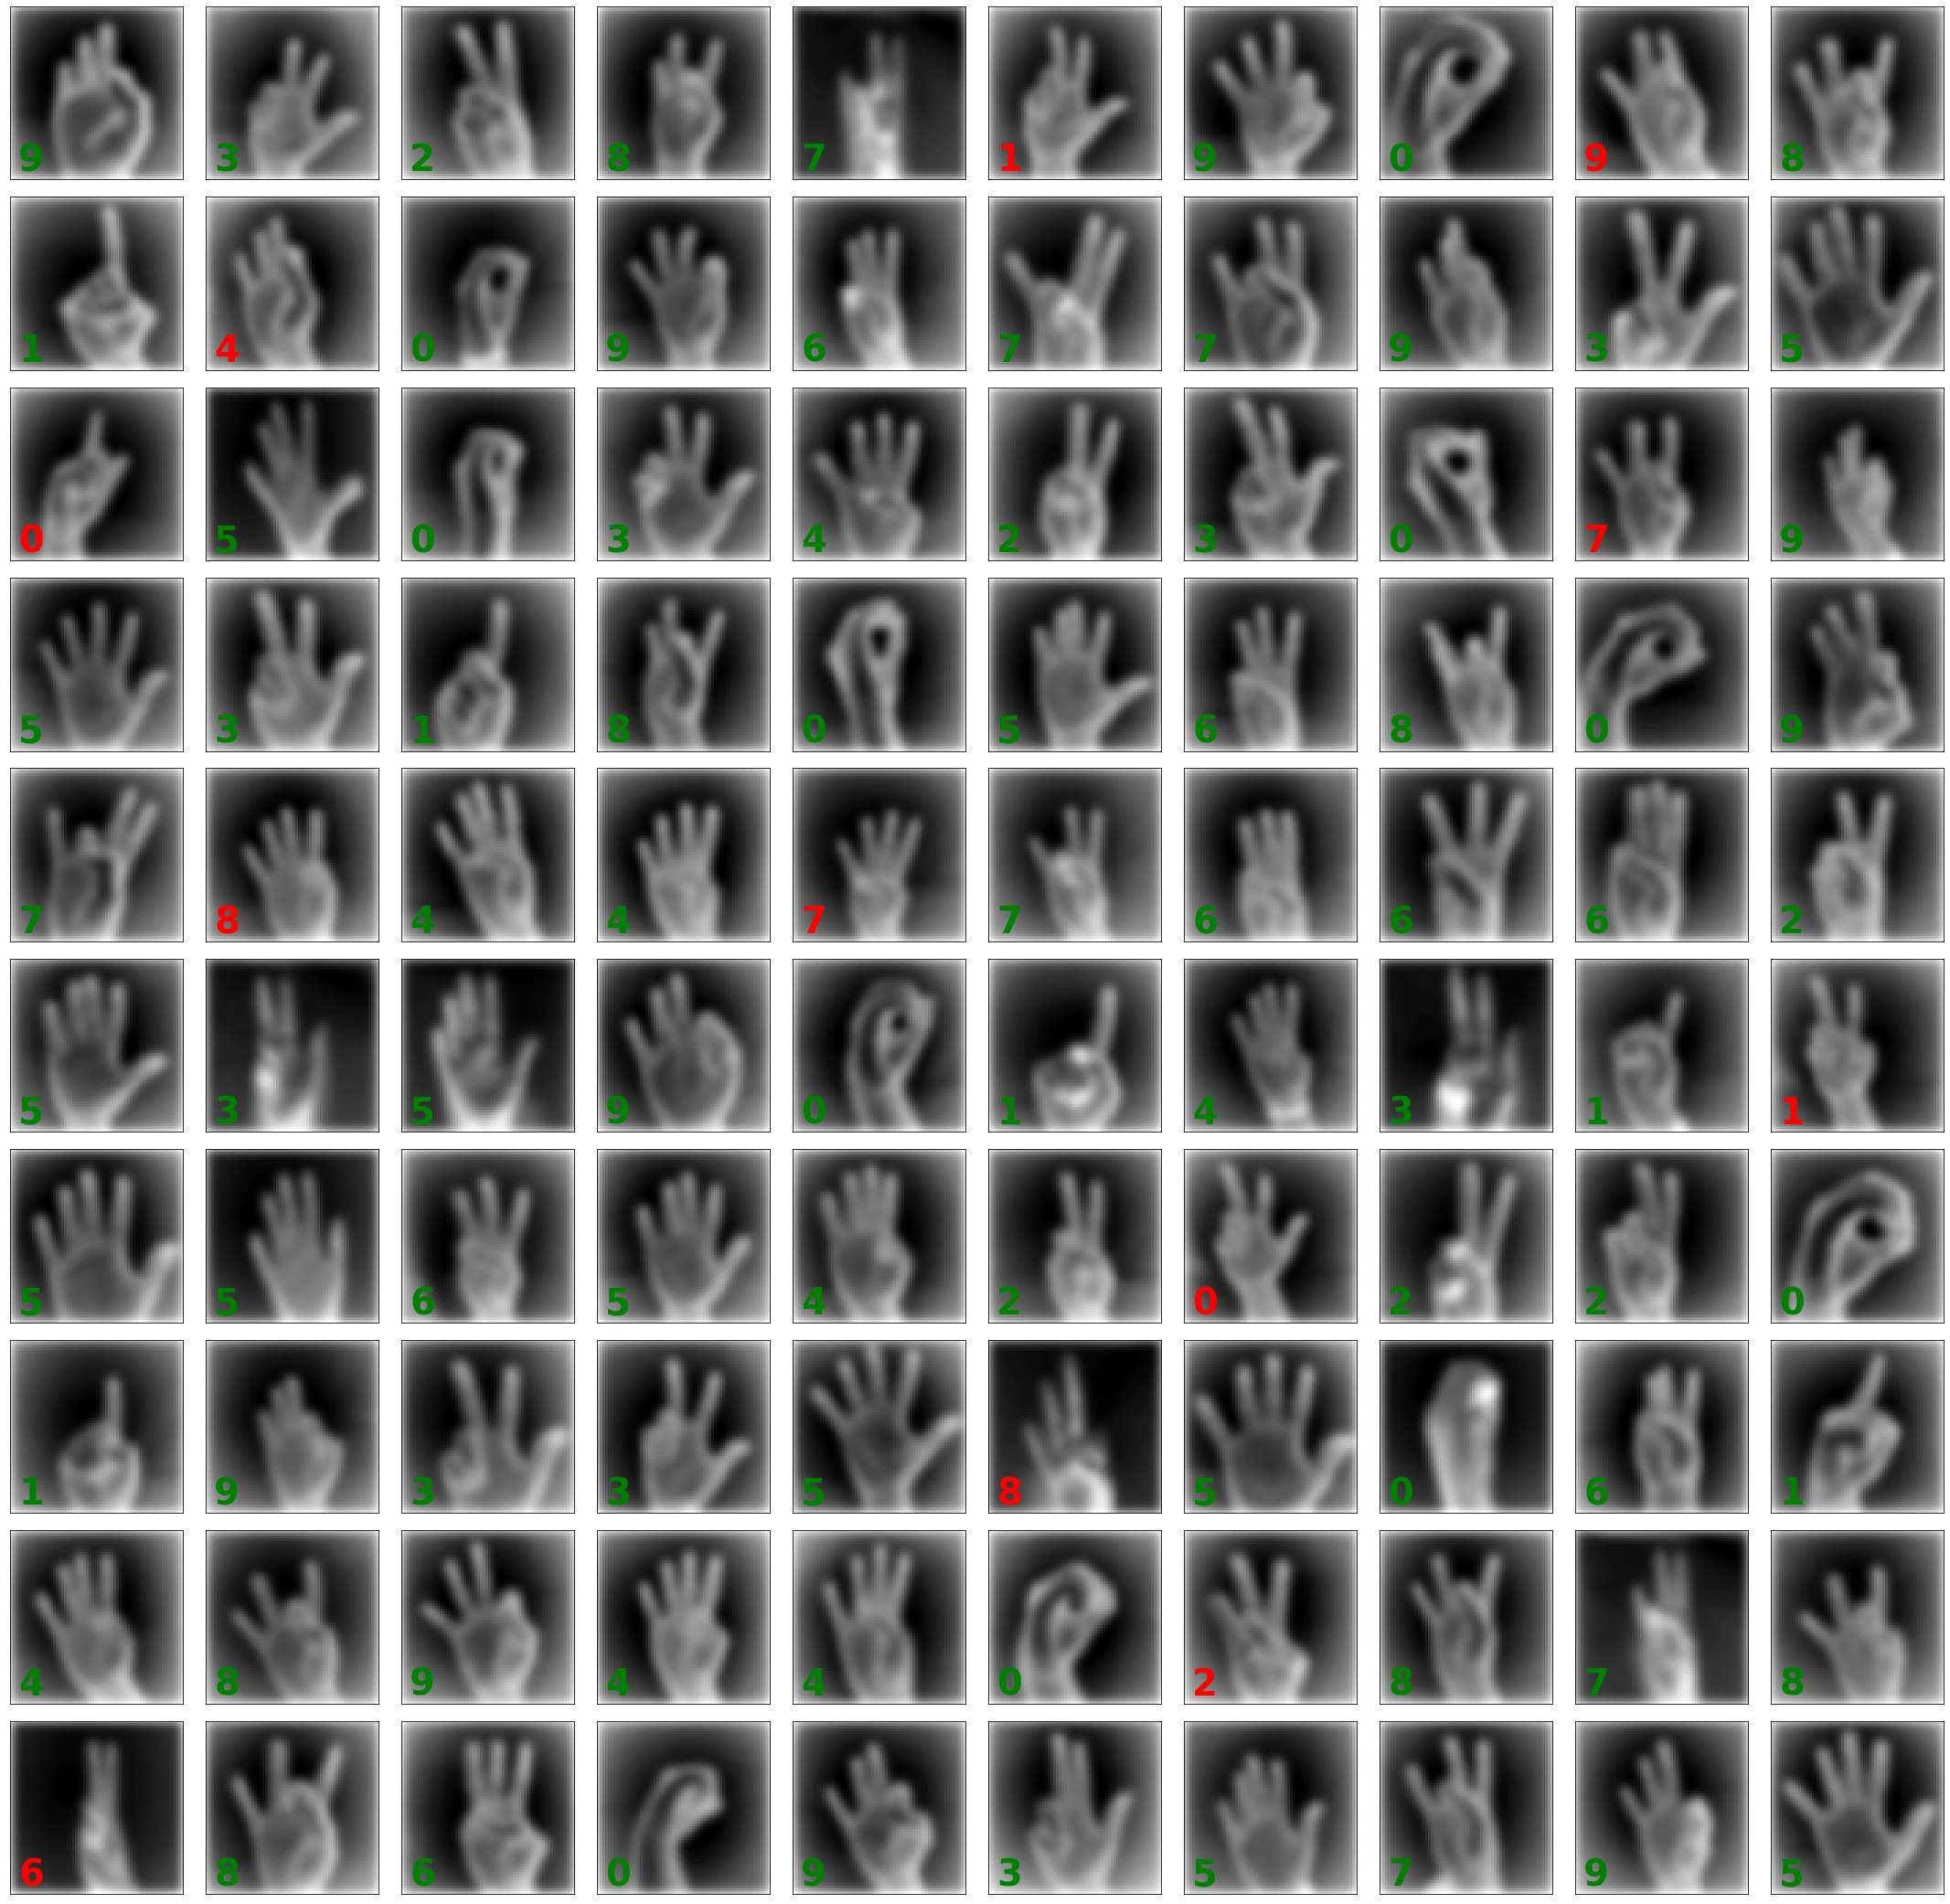

In [107]:
fig, axes = plt.subplots(10, 10, figsize=(38, 38),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

test_images = XtestGauss.reshape(-1, 64, 64)

for i, ax in enumerate(axes.flat):
    ax.imshow(test_images[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(Ymodel[i]),
            transform=ax.transAxes, fontsize = 40, fontweight = 'bold',
            color='green' if (Ytest[i] == Ymodel[i]) else 'red')